In [159]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sortedcontainers import SortedList
from sklearn.model_selection import train_test_split
import math
import re
from datetime import datetime


In [160]:
# Tien xu lli du lieu
file_path = '../dataset/test.likes.csv'
data = []
with open(file_path, 'r', newline='') as file:
    reader = csv.DictReader(file)
    for row in reader:
        data.append(row)
for row in data:
    del row['_id']
    del row['createdAt']
    del row['__v']
    row['liked'] = 1
with open('liked_final.csv', 'w', newline='') as file:
    fieldnames = data[0].keys()
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for row in data:
        writer.writerow(row)


In [161]:
df = pd.read_csv('liked_final.csv')
tour_df = pd.read_csv('../dataset/test.tours.csv')
df = shuffle(df)

df_train, df_test = train_test_split(df)


In [162]:
print(tour_df)

                          _id   
0    65ba0f8acfbe79273d91e0dc  \
1    65cc76cf4da78f7cdfcc4f5b   
2    65cc798ee1151b941e7659bb   
3    65ccf12fd3f9970b03f54e2f   
4    65d89bbdc3a7e98c44a12d7a   
..                        ...   
462  65db0c680b1aa37831a6b7f3   
463  65db0c680b1aa37831a6b7f5   
464  65db0c680b1aa37831a6b7f7   
465  65db0c690b1aa37831a6b7f9   
466  65db0c690b1aa37831a6b7fb   

                                                  name   
0    Du lịch Tết Âm lịch - Tour Thái Lan - Thiên Đư...  \
1    Du lịch Tết Âm lịch - Tour Thái Lan - Thiên Đư...   
2                                        Du lịch Bà Nà   
3    Du lịch Tết Âm lịch - Tour Thái Lan - Thiên Đư...   
4    Du lịch Miền Bắc mùa Xuân Hà Nội - Chùa Tam Ch...   
..                                                 ...   
462  Du lịch Đồng Tháp Làng Hoa Sa Đéc - Vườn Quýt ...   
463  Du lịch Hè - Tour Du lịch Đồng Tháp Làng hoa S...   
464  Du lịch Đồng Tháp - Làng Hoa Sa Đéc - Vườn Quý...   
465  Du lịch Đồng Tháp 

In [163]:
user_to_tour = {}
tour_to_user = {}
tour_user_liked = {}
tour_user_liked_train = {}
tour_user_liked_test = {}


for row in df.values:
    user_id, tour_id, liked = row
    if tour_id not in user_to_tour:
        user_to_tour[user_id] = [tour_id]
    else:
        user_to_tour[user_id].append(tour_id)
    
    if tour_id not in tour_to_user:
        tour_to_user[tour_id] = [user_id]
    else:
        tour_to_user[tour_id].append(user_id)
    
    tour_user_liked[(tour_id, user_id)] = liked


In [164]:
for row in df_train.values:
    user_id, tour_id, liked = row
    tour_user_liked_train[(tour_id, user_id)] = liked

for row in df_test.values:
    user_id, tour_id, liked = row
    tour_user_liked_test[(tour_id, user_id)] = liked


In [165]:
number_of_tour= int(len(tour_to_user.keys()))
number_of_user = int(len(user_to_tour.keys()))

print(f'Number of movie has liked: {number_of_tour}')
print(f'Number of user liked: {number_of_user}')

Number of movie has liked: 222
Number of user liked: 32


In [166]:
# latent dimensionality
k = 30
W = dict.fromkeys(user_to_tour.keys())
U = dict.fromkeys(tour_to_user.keys())
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [167]:
def get_rating(user_id, tour_id):
    return sigmoid(np.dot(W[user_id], U[tour_id]))
def convert_to_hours(period_string):
        try:
            days = int(period_string.split('ngày')[0])
        except:
            days = 0
        try:
            nights = int(period_string.split('đêm')[0])
        except:
            nights = 0
        total_hours = (days + nights) * 12
        return total_hours
def get_rating_content_based(user_id, tour_id):
    tours = {}
    for row in tour_df.values:
        _id,name,description,price,departureLocation,period,images,destination,departureDay,createdAt,__v,numLikes = row
        tours[_id] = {
            'name': name,
            'description': description,
            'price': price,
            'departureLocation': departureLocation,
            'period': convert_to_hours(period),
            'images': images,
            'destination': destination,
            'departureDay': departureDay,
            'createdAt': createdAt,
            'numLikes': numLikes
        }
    def get_sim_name(tour_id_i,tour_id_j):
        name_i = tours[tour_id_i]['name']
        name_j = tours[tour_id_j]['name']

        tokens_i = re.findall(r'\w+', name_i.lower())
        tokens_j = re.findall(r'\w+', name_j.lower()) 

        common_tokens = set(tokens_i) & set(tokens_j)
        similarity = len(common_tokens) / len(name_i)

        return similarity
    def get_sim_departureLocation(tour_id_i,tour_id_j):
        departureLocation_i = set(tours[tour_id_i]['departureLocation'])
        departureLocation_j = set(tours[tour_id_j]['departureLocation'])

        return (len(departureLocation_i.intersection(departureLocation_j))/len(departureLocation_i.union(departureLocation_j)))
    def get_sim_price(tour_id_i,tour_id_j):
        price_i = tours[tour_id_i]['price']
        price_j = tours[tour_id_j]['price']

        if price_i == 0 or price_j == 0:
            return 0
        max_price = max(price_i, price_j)

        normalized_price_i = (max_price - price_i) / max_price
        normalized_price_j = (max_price - price_j) / max_price

        similarity = abs(normalized_price_i - normalized_price_j)

        return similarity

    def get_sim_period(tour_id_i,tour_id_j):
        period_i = tours[tour_id_i]['period']
        period_j = tours[tour_id_j]['period']
        diff = abs(period_i - period_j)
        if diff < 12:
            return 1
        elif diff < 24:
            return 0.8
        elif diff < 48:
            return 0.6
        return 0
    def get_sim_departureDays(tour_id_i,tour_id_j):
        departure_day_i = datetime.fromisoformat(tours[tour_id_i]['departureDay'].split('T')[0])
        departure_day_j = datetime.fromisoformat(tours[tour_id_j]['departureDay'].split('T')[0])

        similarity = 1 / (1 + abs((departure_day_i - departure_day_j).days))

        return similarity
    def get_tour_similarities(tour_id_i,tour_id_j):
        sim_name = get_sim_name(tour_id_i,tour_id_j)
        sim_departureLocation = get_sim_departureLocation(tour_id_i,tour_id_j)
        sim_price = get_sim_price(tour_id_i,tour_id_j)
        sim_period = get_sim_period(tour_id_i,tour_id_j)
        sim_departureDays = get_sim_departureDays(tour_id_i,tour_id_j)
        return 0.2 * (sim_name + sim_departureLocation + sim_price + sim_period + sim_departureDays)
    sim = []
    for tour_id_user_liked in user_to_tour[user_id]:
        sim.append(get_tour_similarities(tour_id_user_liked, tour_id))
    print('rating',get_rating(user_id, tour_id))
    print('sim',np.mean(sim))
    print('final_rating', np.mean(sim) * get_rating(user_id, tour_id))
    return np.mean(sim) * get_rating(user_id, tour_id)





In [168]:
def evaluate():
    loss = 0
    for tour_id, user_id in tour_user_liked_test:
        liked = tour_user_liked_test[(tour_id, user_id)]
        error = liked - get_rating(user_id, tour_id)

        loss += error ** 2
    return (loss, math.sqrt(loss / len(tour_user_liked_test)))

In [169]:
def dump():
    for user_id in W.keys():
        W[user_id] = np.random.randn(k)
    for movie_id in U.keys():
        U[movie_id] = np.random.randn(k)
# fit(100, 0.01, 0.2, matrix_fact_with_bias, evaluate_with_bias)
def fit(epoch, learning_rate, weight, update_func, evaluate_func):
    losses_train = []
    losses_validation = []

    rmse_train = []
    rmse_validation = []

    dump()

    for i in range(0, epoch):
        loss = 0    
        
        for tour_id, user_id in tour_user_liked_train:
            loss += update_func((tour_id, user_id, learning_rate, weight))

        rmse = math.sqrt(loss / len(tour_user_liked_train))

        loss_test, rmse_test = evaluate_func()
        
        losses_train.append(loss)
        losses_validation.append(loss_test)

        rmse_train.append(rmse)
        rmse_validation.append(rmse_test)

        print(f'Epoch: {i + 1}/{epoch}')
        print('Loss: ' , loss, 'RMSE: ', rmse, 'Loss_Test: ', loss_test, 'RMSE_Test: ', rmse_test)

    x_axis = list(range(1, epoch + 1))
    fig, axis = plt.subplots(nrows = 1, ncols = 2)

    axis[0].plot(x_axis, losses_train, color = 'red', label = 'Loss Train')
    axis[0].set_xlabel('Epoch')
    axis[0].set_ylabel('Loss')

    axis[0].plot(x_axis, losses_validation, color = 'blue', label = 'Loss Test')
    axis[0].legend(loc = 'upper right')

    axis[1].plot(x_axis, rmse_train, color = 'red', label = 'RMSE Train')
    axis[1].set_xlabel('Epoch')
    axis[1].set_ylabel('RMSE')

    axis[1].plot(x_axis, rmse_validation, color = 'blue', label = 'RMSE Test')
    axis[1].legend(loc = 'upper right')
    plt.show()

In [170]:
def matrix_fact(args):
    tour_id, user_id, learning_rate, _ = args
    rate = tour_user_liked_train[(tour_id, user_id)]
    
    error = rate - np.dot(W[user_id], U[tour_id])
    
    saved_w = np.copy(W[user_id])
    saved_u = np.copy(U[tour_id])

    W[user_id] += 2 * learning_rate * error * saved_u
    U[tour_id] += 2 * learning_rate * error * saved_w

    return error ** 2
def matrix_fact_with_bias(args):
    tour_id, user_id, learning_rate, weight = args
    liked = tour_user_liked_train[(tour_id, user_id)]
    predict_liked = np.dot(W[user_id], U[tour_id])
    error = liked - predict_liked
    saved_w = np.copy(W[user_id])
    saved_u = np.copy(U[tour_id])

    W[user_id] += learning_rate * (2 * error * saved_u - weight * saved_w)
    U[tour_id] += learning_rate * (2 * error * saved_w - weight * saved_u)

    return error ** 2



Epoch: 1/100
Loss:  6660.375086584037 RMSE:  5.920693010016931 Loss_Test:  26.25706203261363 RMSE_Test:  0.6405205650559457
Epoch: 2/100
Loss:  790.7168566230064 RMSE:  2.040016584843583 Loss_Test:  26.38900932994414 RMSE_Test:  0.6421279239998656
Epoch: 3/100
Loss:  123.51984675217207 RMSE:  0.8062905534547575 Loss_Test:  26.347246394483037 RMSE_Test:  0.6416196107615457
Epoch: 4/100
Loss:  17.83181040922452 RMSE:  0.3063521400819009 Loss_Test:  26.360743848872243 RMSE_Test:  0.6417839376601979
Epoch: 5/100
Loss:  2.4920871476031237 RMSE:  0.11452618977893046 Loss_Test:  26.35897906716552 RMSE_Test:  0.6417624544365783
Epoch: 6/100
Loss:  0.4523018761529171 RMSE:  0.04879073877569914 Loss_Test:  26.364067730849882 RMSE_Test:  0.6418243983322303
Epoch: 7/100
Loss:  0.10984423136394521 RMSE:  0.024044282761073336 Loss_Test:  26.36239539151136 RMSE_Test:  0.6418040417388823
Epoch: 8/100
Loss:  0.029639299806974162 RMSE:  0.0124898484687985 Loss_Test:  26.362997312327263 RMSE_Test:  0.641

Epoch: 69/100
Loss:  1.509929076399593e-29 RMSE:  2.819041528417988e-16 Loss_Test:  26.363164075585686 RMSE_Test:  0.6418133986456082
Epoch: 70/100
Loss:  1.495137934426699e-29 RMSE:  2.805199997023103e-16 Loss_Test:  26.363164075585686 RMSE_Test:  0.6418133986456082
Epoch: 71/100
Loss:  1.4125540584113743e-29 RMSE:  2.726627045319985e-16 Loss_Test:  26.363164075585686 RMSE_Test:  0.6418133986456082
Epoch: 72/100
Loss:  1.8168452723371428e-29 RMSE:  3.092303920803474e-16 Loss_Test:  26.363164075585686 RMSE_Test:  0.6418133986456082
Epoch: 73/100
Loss:  1.5210224328792634e-29 RMSE:  2.8293782401227896e-16 Loss_Test:  26.363164075585686 RMSE_Test:  0.6418133986456082
Epoch: 74/100
Loss:  1.566628453962353e-29 RMSE:  2.871482703341835e-16 Loss_Test:  26.363164075585686 RMSE_Test:  0.6418133986456082
Epoch: 75/100
Loss:  1.829171223981221e-29 RMSE:  3.102775687722562e-16 Loss_Test:  26.363164075585686 RMSE_Test:  0.6418133986456082
Epoch: 76/100
Loss:  1.867381674077864e-29 RMSE:  3.135015

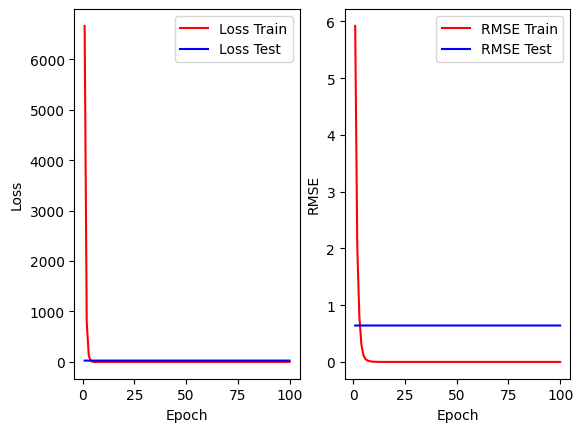

In [171]:
# fit(100, 0.01, 0.2, matrix_fact, evaluate)
fit(100, 0.01, 0.2, matrix_fact, evaluate)

In [172]:
def get_top_n(user_id, get_rating_func, n = 10):
    recommend_list = SortedList()
    for tour_id in tour_to_user.keys():
        if (tour_id, user_id) not in tour_to_user:
            rating = get_rating_func(user_id, tour_id)
            recommend_list.add((rating, tour_id))
            if len(recommend_list) > n:
                del recommend_list[0]
    return recommend_list

get_top_n('65bb108c8c4d4a714df1aaf4', get_rating_content_based)


rating 0.9760470916452155
sim 0.2932241758241758
final_rating 0.28620060401325215
rating 0.9494275834408659
sim 0.4534174241758242
final_rating 0.4304870093252348
rating 0.5560562882091687
sim 0.44988628864468866
final_rating 0.2501620997799643
rating 0.9996876486660754
sim 0.4569558857142857
final_rating 0.4568131549338381
rating 0.10184747117621847
sim 0.4994182381766383
final_rating 0.05086448461757297
rating 0.5160710535064452
sim 0.4949412336996337
final_rating 0.25542484389914966
rating 0.09850835291188846
sim 0.38297783882783887
final_rating 0.03772651610468509
rating 0.7310585786300049
sim 0.46001083076923077
final_rating 0.33629486409656156
rating 0.9938561099112053
sim 0.46001083076923077
final_rating 0.4571845747853295
rating 0.6682100204519955
sim 0.4531707819291819
final_rating 0.30281325746114546
rating 0.006459657980379349
sim 0.47274432234432234
final_rating 0.003053766634510529
rating 0.9997645467156604
sim 0.5059733388493859
final_rating 0.5058542057649655
rating 0.93

SortedList([(0.4989198708695358, '65db0c220b1aa37831a6b65f'), (0.5002333222618787, '65db0c230b1aa37831a6b665'), (0.5027841382521159, '65db0c380b1aa37831a6b6df'), (0.5053520061614036, '65db0c470b1aa37831a6b735'), (0.5058542057649655, '65db0c3f0b1aa37831a6b709'), (0.5130022028732142, '65db0c140b1aa37831a6b60f'), (0.514852605438112, '65db0c360b1aa37831a6b6d5'), (0.5282103772171055, '65db0c390b1aa37831a6b6e5'), (0.5310812844120868, '65db0c640b1aa37831a6b7dd'), (0.6363966680309401, '65ccf12fd3f9970b03f54e2f')])